In [1]:
from googlefinance.client import get_price_data, get_prices_data
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from sklearn import linear_model
import arch.unitroot as at
%matplotlib inline
stock1 = 'XOM'
stock2 = 'CVX'

C:\Users\trimu\Miniconda3\envs\py35\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
start = pd.to_datetime('2009-01-01')
end =  pd.to_datetime('2017-01-01')
x = pd.DataFrame(
        get_price_data({'q': stock1, 'i': "86400", 'x': "NYSE", 'p': "20Y" }))['Close'].loc[start : end]
y =pd.DataFrame(
        get_price_data({'q': stock2, 'i': "86400", 'x': "NYSE", 'p': "20Y" }))['Close'].loc[start : end]
price = pd.concat([x, y], axis=1)
price.columns = [stock1, stock2]
price.index = pd.to_datetime(price.index.date)

In [3]:
lp = np.log(price)
lp[stock1 + '_return'] = lp[stock1].pct_change()
lp[stock2 + '_return'] = lp[stock2].pct_change()

In [4]:
lp.head()

,XOM,CVX,XOM_return,CVX_return
2009-01-01,4.379899,4.303660,NaN,NaN
2009-01-03,4.402319,4.337552,0.005119,0.007875
2009-01-06,4.402197,4.339380,-0.000028,0.000421
2009-01-07,4.385770,4.348341,-0.003732,0.002065
2009-01-08,4.359909,4.303524,-0.005897,-0.010306


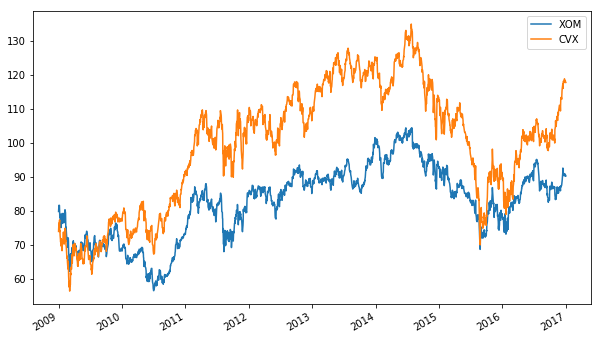

In [5]:
price.plot(figsize = (10,6))

In [6]:
#x_constant = pd.concat([x,pd.Series([1]*len(x),index = x.index)], axis=1)
#x_constant.head()

In [7]:
def reg(x,y):
    regr = linear_model.LinearRegression()
    x_constant = pd.concat([x,pd.Series([1]*len(x),index = x.index)], axis=1)
    regr.fit(x_constant, y)    
    beta = regr.coef_[0]
    alpha = regr.intercept_
    spread = y - x*beta - alpha
    return spread

Text(0.5,0.98,'XOM-CVX spread')

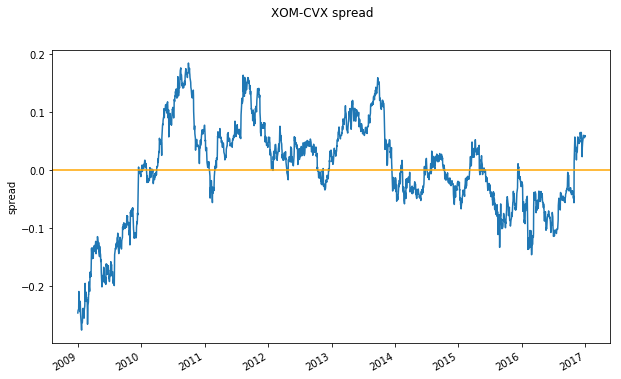

In [8]:
x = lp['XOM']
y = lp['CVX']
spread = reg(x,y)
# plot the spread series
spread.plot(figsize =(10,6))
plt.axhline(spread.mean(), color='orange')
plt.ylabel('spread');
plt.suptitle(stock1 + '-' + stock2 + ' spread')

### 두 주식의 Price 의 Correlation Test

In [9]:
np.corrcoef(price[stock1], price[stock2])

array([[ 1.        ,  0.90860379],
       [ 0.90860379,  1.        ]])

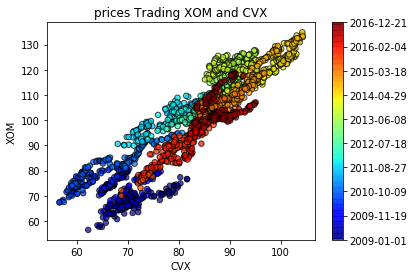

In [10]:
colors = np.linspace(0.1, 1, len(price))
plt.figure(figsize=(6,4))

sc = plt.scatter(price[stock1], price[stock2], s=30, c=colors, cmap=plt.get_cmap('jet'), edgecolor='k',
                alpha=0.7)
cb = plt.colorbar(sc)

cb.ax.set_yticklabels([str(p.date()) for p in price[::len(price)//9].index]);

plt.xlabel(stock2)
plt.ylabel(stock1)
plt.title('prices Trading ' + stock1 + ' and ' + stock2);

### stock1 과 stock2 가 pairs trading 의 조건을 만족하는지 TEST

1. stock1-stock2 price(cum return) 가 stationary 인지 test
2. stock1-stock2 spread 가 stationary 인지 test
    * Augment Dickey-Fuller Co-integration test
    * Phillips-Perron Co-integration test (double check)

In [11]:
at.ADF(spread)

Test Statistic,-3.218
P-value,0.019
Lags,0


### stock1 과 stock2 의 spread 는 stationary 이다.

In [12]:
at.PhillipsPerron(spread)   # double check

Test Statistic,-3.128
P-value,0.025
Lags,26


### 두가지 test 의 p-value < 0.05 이므로 stock1-stock2 의 spread 가 stationary 이므로, 두 주식은 co-integration 되어 있다.

### daily return 이 stationary 하고 상호 cointegration 되어 있으므로 Pairs Trading 의 조건을 만족시킨다.

### stock1-stock2 rolling beta 계산

In [13]:
window = 20

In [14]:
rolling_cov = price.loc[:, [stock1, stock2]].rolling(window).cov(price.loc[:, [stock1, stock2]], pairwise=True)

In [15]:
idx = pd.IndexSlice
rolling_cov = rolling_cov.loc[idx[:, stock1], stock2].reset_index(level=1)

In [16]:
rolling_var = price[stock2].rolling(window).var()

In [17]:
price['rolling_beta'] = rolling_cov[stock2] / rolling_var

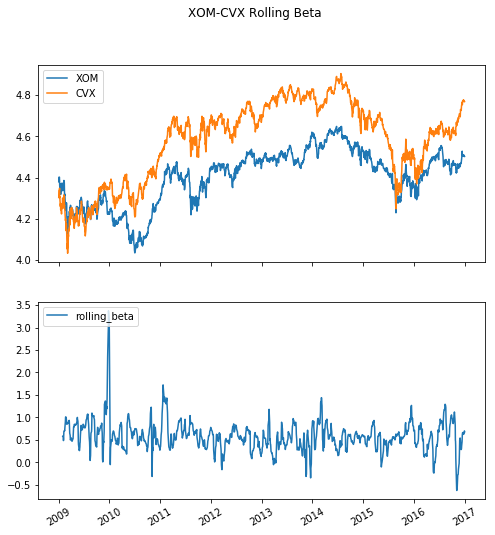

In [18]:
fig3, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,8))

ax1.plot(lp[stock1])
ax1.plot(lp[stock2])
ax1.legend()

ax2.plot(price['rolling_beta'])
ax2.legend(loc="upper left")
plt.suptitle(stock1 + '-' + stock2 + ' Rolling Beta')
plt.xticks(rotation=30);

In [19]:
price['rolling_spread'] = price[stock1] - price['rolling_beta'] * price[stock2]
rolling_mean = price['rolling_spread'].rolling(window).mean()
rolling_std = price['rolling_spread'].rolling(window).std()

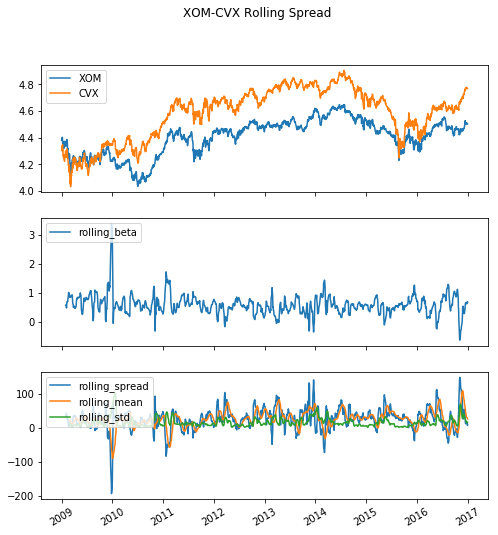

In [20]:
fig4, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))

ax1.plot(lp[stock1])
ax1.plot(lp[stock2])
ax1.legend()

ax2.plot(price['rolling_beta'])
ax2.legend(loc="upper left")

ax3.plot(price['rolling_spread'])
ax3.plot(rolling_mean, label='rolling_mean')
ax3.plot(rolling_std, label='rolling_std')
ax3.legend(loc="upper left")
plt.suptitle(stock1 + '-' + stock2 + ' Rolling Spread')
plt.xticks(rotation=30);

### stock1-stock2 Rolling Spread Z-Score calculation and Chart

In [21]:
price['rolling_zscore'] = (price['rolling_spread'] - rolling_mean) / rolling_std

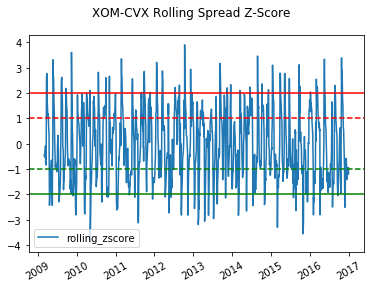

In [22]:
fig5, ax = plt.subplots()
ax.plot(price['rolling_zscore'])
ax.axhline((-2), color='green')
ax.axhline((-1), color='green', linestyle='--')
ax.axhline((+2), color='red')
ax.axhline((+1), color='red', linestyle='--')
ax.legend(loc="lower left")
plt.xticks(rotation=30)
plt.suptitle(stock1 + '-' + stock2 + ' Rolling Spread Z-Score');

### Trading Signal  and chart

In [23]:
price['rolling_zscore(-1)'] = price['rolling_zscore'].shift(1)  # current zscore
price['rolling_zscore(-2)'] = price['rolling_zscore'].shift(2)  # previous zscore
price['signal'] = 0
for i, r in enumerate(price.iterrows()):
    if r[1]['rolling_zscore(-2)'] > -2 and r[1]['rolling_zscore(-1)'] < -2:    # Enter Long
        signal = -2
    elif r[1]['rolling_zscore(-2)'] < -1 and r[1]['rolling_zscore(-1)'] > -1:  # Exit Long
        signal = -1
    elif r[1]['rolling_zscore(-2)'] < 2 and r[1]['rolling_zscore(-1)'] > 2:     # Enter Short
        signal = 2
    elif r[1]['rolling_zscore(-2)'] > 1 and r[1]['rolling_zscore(-1)'] < 1:      # Exit Short
        signal = 1
    else:
        signal = 0
    price.iloc[i, price.columns.get_loc('signal')] = signal

In [36]:
sum(price['signal'] != 0)

217

In [24]:
price['position'] = 0
position = 0
for i, r in enumerate(price.iterrows()):
    if r[1]['signal'] == -2:
        position = 1
    elif r[1]['signal'] == 2:
        position = -1
    elif r[1]['signal'] == -1 or  r[1]['signal'] == 1:
        position = 0
    else:
        position = price.loc[:, 'position'][i - 1]
    price.iloc[i, price.columns.get_loc('position')] = position

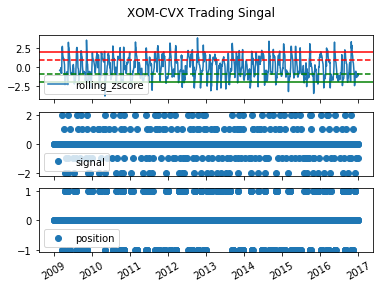

In [25]:
fig6, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)

ax1.plot(price['rolling_zscore'])
ax1.axhline((-2), color='green')
ax1.axhline((-1), color='green', linestyle='--')
ax1.axhline((+2), color='red')
ax1.axhline((+1), color='red', linestyle='--')
ax1.legend(loc="lower left")

ax2.plot(price['signal'], marker='o', linestyle='')
ax2.legend(loc='lower left')

ax3.plot(price['position'], marker='o', linestyle='')
plt.xticks(rotation=30)
ax3.legend(loc='lower left')
plt.suptitle(stock1 + '-' + stock2 + ' Trading Singal');

In [26]:
price['spread_return'] = lp[stock1 + '_return'] - price['rolling_beta'] *lp[stock2 + '_return']
price['return'] = price['spread_return'] * price['position']

In [27]:
price['position(-1)'] = price['position'].shift(1)
price['commission'] = 0

In [28]:
for i, r in enumerate(price.iterrows()):
    if (r[1]['signal'] == -2 or r[1]['signal'] == -1 or r[1]['signal'] == 2 or r[1]['signal'] == 1 ) and \
        r[1]['position'] != r[1]['position(-1)']:
        #commission = 0.0016
        commission = 0
    else:
        commission = 0
    price.iloc[i, price.columns.get_loc('commission')] = commission

In [29]:
price['return_c'] = price['return'] - price['commission']

## Performance Backtest

Cummulative Annualized Return and Chart

In [30]:
price[np.isnan(price)] = 0
price['ann_return'] = np.cumprod(price['return_c'] + 1) ** (252/len(price)) - 1
price['ann_' + stock1] = np.cumprod(lp[stock1 + '_return'] + 1) ** (252/len(price)) - 1
price['ann_' + stock2] = np.cumprod(lp[stock2 + '_return'] + 1) ** (252/len(price)) - 1

In [31]:
price.tail()

,XOM,CVX,rolling_beta,rolling_spread,rolling_zscore,rolling_zscore(-1),rolling_zscore(-2),signal,position,spread_return,return,position(-1),commission,return_c,ann_return,ann_XOM,ann_CVX
2016-12-24,90.71,118.42,0.628857,16.240776,-0.966367,-1.001452,-1.123088,0,0,-0.000002,-0.0,0.0,0,-0.0,0.002114,0.003603,0.013062
2016-12-28,90.75,118.22,0.635439,15.628442,-0.948299,-0.966367,-1.001452,-1,0,0.000323,0.0,0.0,0,0.0,0.002114,0.003615,0.013017
2016-12-29,90.30,117.91,0.662913,12.135940,-1.073241,-0.948299,-0.966367,0,0,-0.000738,-0.0,0.0,0,-0.0,0.002114,0.003476,0.012948
2016-12-30,90.35,117.82,0.699008,7.992868,-1.195515,-1.073241,-0.948299,0,0,0.000235,0.0,0.0,0,0.0,0.002114,0.003492,0.012927
2016-12-31,90.26,117.70,0.676757,10.605751,-0.947608,-1.195515,-1.073241,0,0,-0.000077,-0.0,0.0,0,-0.0,0.002114,0.003464,0.012900


C:\Users\trimu\Miniconda3\envs\py35\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


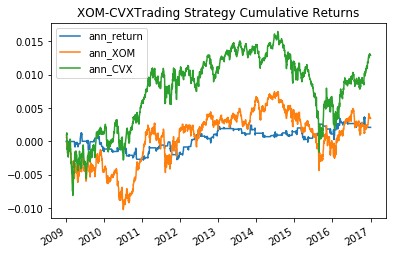

In [32]:
price.plot(y=['ann_return', 'ann_' + stock1, 'ann_' + stock2])
plt.title(stock1 + '-' + stock2 + 'Trading Strategy Cumulative Returns');